# Zuppa R-CNN Stage 2



In [23]:
# Import the required modules for MaskRCNN
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import collections
from imgaug import augmenters as iaa
from datetime import datetime

In [28]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:

# Root directory of the project
# ROOT_DIR = os.path.abspath("C:/mask/Mask_RCNN/")
MASK_RCNN_ROOT_DIR = "../Mask_RCNN/"
COCO_ROOT_DIR = "."

# Import Mask RCNN
sys.path.append(MASK_RCNN_ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(COCO_ROOT_DIR, "samples/zuppa/"))  # To find local version
import zuppa as coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(COCO_ROOT_DIR, "logs")

# Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(COCO_ROOT_DIR, "mask_rcnn_zuppa_0091.h5")
# COCO_MODEL_PATH = os.path.join(COCO_ROOT_DIR, "logs/zuppa20190305T1602/mask_rcnn_zuppa_0043.h5") #lowest validation loss
# COCO_MODEL_PATH = os.path.join(COCO_ROOT_DIR, "logs/zuppa20190305T1602/mask_rcnn_zuppa_0100.h5") #max epoch before augmentation
# COCO_MODEL_PATH = os.path.join(COCO_ROOT_DIR, "logs/zuppa20190305T1602/mask_rcnn_zuppa_0127.h5") #epoch with augmentation (teh best one)
COCO_MODEL_PATH = os.path.join(COCO_ROOT_DIR, "logs/zuppa20190305T1602/mask_rcnn_zuppa_0149.h5") #before extreme augmentation & training all data
# COCO_MODEL_PATH = os.path.join(COCO_ROOT_DIR, "logs/zuppa20190305T1602/mask_rcnn_zuppa_0174.h5") #extreme augmentation & train all data #likely overfit
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "samples/zuppa/dataset/train") #test back on images used for training
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "samples/zuppa/dataset/val") #test on images used for validation (proper)
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "images") #other directory for testing
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "images2") #other directory for testing
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "images3") #other directory for testing


/home/zuppa/anaconda3/envs/opencv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zuppa/anaconda3/envs/opencv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zuppa/anaconda3/envs/opencv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zuppa/anaconda3/envs/opencv/lib/python3.6/s

In [3]:
# Check if GPU used (prints in console/terminal)

import tensorflow as tf;
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

False

In [4]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9323179524013928235
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10228094239990749550
physical_device_desc: "device: XLA_CPU device"
]


In [5]:
class InferenceConfig(coco.BalloonConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE=0.7
    DETECTION_MAX_INSTANCES=10

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

## Create Model and Load Trained Weights

In [6]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 149


In [7]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'Sour', 'Tiger', 'Flower', 'Lychee', 'Milo']

In [20]:

def class_id_to_class_name(class_id):
    return class_names[class_id]



def detect(image):
# Run detection
    SHOW_VERBOSE = False
#     SHOW_VERBOSE = True
    results = model.detect([image], verbose=SHOW_VERBOSE)

#     print(len(results))

    # Visualize results
    r = results[0] #so far there's only 1 result

    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'])


    detected_class_names = list(map(class_id_to_class_name, r['class_ids']))
#     print(detected_class_names)
#     print(list(zip(r['class_ids'], r['scores'])))
#     print(list(zip(detected_class_names, r['scores'])))

    # ref https://stackoverflow.com/a/2162045/3553367
    counter=collections.Counter(detected_class_names)
    # ref: https://stackoverflow.com/a/17930886/3553367
    count_items = sorted(counter.items())
    print(count_items)
    
    return count_items

In [9]:
# Import the required modules for Webcam
import cv2
import time
import numpy as np
import PIL.Image
from io import BytesIO
import IPython.display
import ipywidgets as widgets

# Functions for webcam

#Use 'jpeg' instead of 'png' (~5 times faster)
def showarray(a, prev_display_id=None, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    if prev_display_id is not None:
        IPython.display.update_display(obj, display_id=prev_display_id)
        return prev_display_id
    else:
        return IPython.display.display(obj, display_id=True)
    
def get_frame(cam):
    # Capture frame-by-frame
    ret, frame = cam.read()
    
    #flip image for natural viewing
#     frame = cv2.flip(frame, 1)
    
    return frame

cameras = []

def init_cameras():
    
    for usb_camera in usb_cameras:

        cam = cv2.VideoCapture(usb_camera.get('path'))

#         cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
#         cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
        cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
        cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
        
#         cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
#         cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

#         cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
#         cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)


    #     cam.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0.25) #ref: https://github.com/opencv/opencv/issues/9738#issuecomment-346584044
    #     cam.set(cv2.CAP_PROP_EXPOSURE, 0.01)
    #     cam.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0)
    #     cam.set(cv2.CAP_PROP_EXPOSURE, -4.0)

        cameras.append({
            "name": usb_camera.get('name'),
            'cam': cam,
            'display_id': None,
            "offset":  usb_camera.get('offset'),
            "discard":  usb_camera.get('discard'),
        })
        
def stop_cameras():      
    for camera in cameras:
        cam = camera.get('cam')
        if(cam):
            cam.release()
        
def test_cams(usb_cameras):
    for usb_camera in usb_cameras:
#         print(index)
        cap = cv2.VideoCapture()
        cap.open(usb_camera.get('path'))
        if cap.isOpened():
            print("active: ", usb_camera.get('path'))
        else:
            print("inactive: ", usb_camera.get('path'))
        cap.release()

In [10]:
usb_cameras = [
    {
        "path": "/dev/zuppacamera0",
        "name": "zuppacamera0",
        "offset": 0.48,
        "discard": ["b"],
    },
    {
        "path": "/dev/zuppacamera1",
        "name": "zuppacamera1",
        "offset": 0.54,
    }
]

print(usb_cameras)
test_cams(usb_cameras)

[{'path': '/dev/zuppacamera0', 'name': 'zuppacamera0', 'offset': 0.48, 'discard': ['b']}, {'path': '/dev/zuppacamera1', 'name': 'zuppacamera1', 'offset': 0.54}]
active:  /dev/zuppacamera0
active:  /dev/zuppacamera1


In [11]:
RUN_CAPTURED = True

captures_dir = "captures" 

captured_dir = "captured" 
#rename folder to use previously captured images.
# Image file names must like:
# 2019-11-10_21:24:38_camera_0.jpg
# 2019-11-10_21:24:38_camera_2.jpg
    
if RUN_CAPTURED:
    print("Will run on images from: " + captured_dir)


Will run on images from: captured


## Capture Images and/or Run Detections

------------------------
1 / 4 images
2019-12-21_17:50:31_camera_zuppacamera1_b.jpg


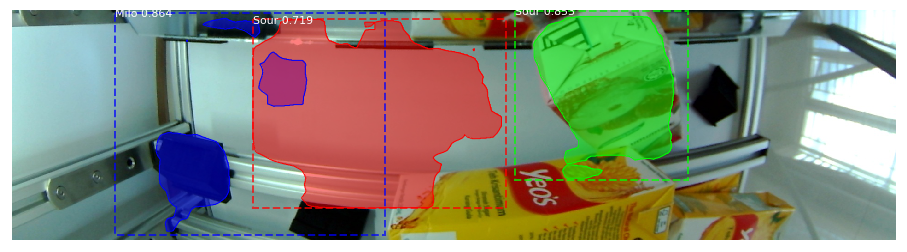

[('Milo', 1), ('Sour', 2)]
12.379819869995117 s
------------------------
2 / 4 images
2019-12-21_17:50:31_camera_zuppacamera1_t.jpg


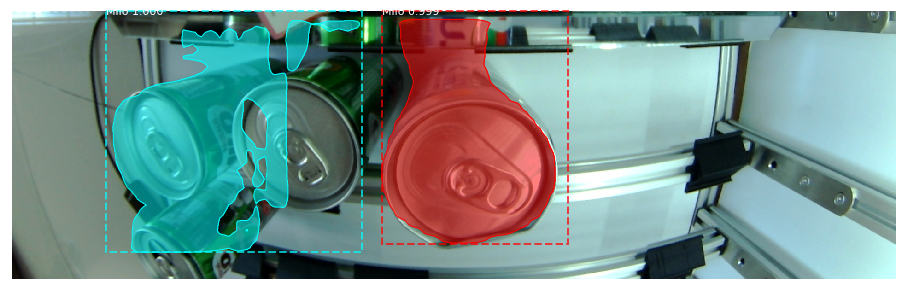

[('Milo', 2)]
10.42161774635315 s
------------------------
3 / 4 images
2019-12-21_17:50:31_camera_zuppacamera0_b.jpg


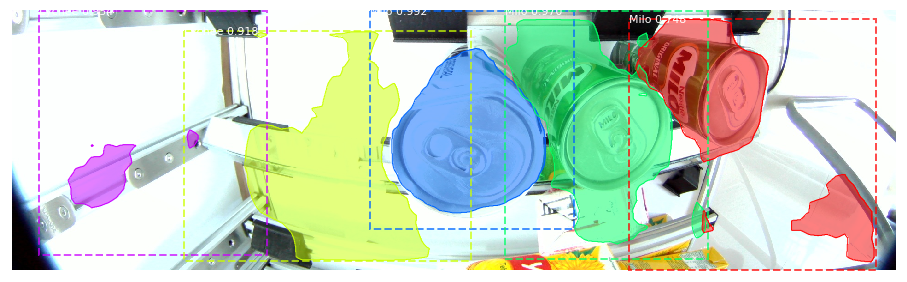

[('Lychee', 2), ('Milo', 3)]
9.99922513961792 s
------------------------
4 / 4 images
2019-12-21_17:50:31_camera_zuppacamera0_t.jpg


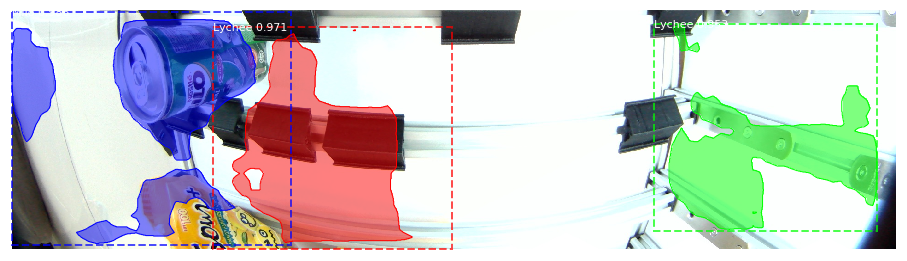

[('Lychee', 2), ('Milo', 1)]
9.591713905334473 s
------DONE------


In [12]:
### RUN OBJECT DETECTION
    
    
import re

# Directory of images to run detection on
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "samples/zuppa/dataset/train") #test back on images used for training
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "samples/zuppa/dataset/val") #test on images used for validation (proper)
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "images") #other directory for testing
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "images2") #other directory for testing
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "images3") #other directory for testing
if RUN_CAPTURED:
    IMAGE_DIR = os.path.join(COCO_ROOT_DIR, captured_dir) #other directory for testing

    # Load a random image from the images folder

    file_names = next(os.walk(IMAGE_DIR))[2] #all
    file_names = list(filter(lambda x: x.endswith('.jpg'), file_names))

    # file_names = [random.choice(file_names)] #random one
    # file_names = [file_names[-1]] #last one


    # print(file_names)
else:
    file_names = [] #do not run on any files
    
    
for index, file_name in enumerate(file_names):
        
    print('------------------------')
    print(index + 1, '/' ,len(file_names), 'images')
    print(file_name)
    
    t1 = time.time()

    offset = 0.
    file_name_search = re.search('(.*)_camera_(.*)_(.*).jpg', file_name, re.IGNORECASE)

    if file_name_search:
        camera_name = file_name_search.group(2)
            
#         print(camera_name)
    
        #ref: https://stackoverflow.com/a/8653568/3553367
        usb_camera =  next(usb_camera for usb_camera in usb_cameras if usb_camera["name"] == camera_name)
        offset = usb_camera.get('offset')
#     print(offset)
        
    image_crop = skimage.io.imread(os.path.join(IMAGE_DIR, file_name))

    
    TEST_AUGMENTATION=True
    TEST_AUGMENTATION=False

    if(TEST_AUGMENTATION):

        augmentation = iaa.Sequential([
            # iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
            iaa.Fliplr(0.5),  # horizontally flip 50% of the images
        #     iaa.Dropout([0.05, 0.1]),
            # blur images with a sigma of 0 to 3.0
            iaa.Sometimes(0.5, iaa.Affine(scale=(0.9, 1.1))),
            iaa.Sometimes(0.5, iaa.Affine(shear=(-16, 16))),
        #     iaa.GaussianBlur(sigma=(0, 1.0)),
            iaa.Sometimes(0.5, iaa.ContrastNormalization((0.7, 1.3))),
            iaa.Sometimes(0.5, iaa.PiecewiseAffine(scale=(0.00, 0.015))),
            iaa.Sometimes(0.5, iaa.ElasticTransformation(alpha=(0, 5.0), sigma=0.25))
        ])

        image_aug = augmentation.augment_image(image_crop)
        skimage.io.imshow(image_aug)
        plt.axis('off')
        plt.show()


    RUN_DETECTION=True    
#         RUN_DETECTION=False

    if(RUN_DETECTION):
        detect(image_crop)
        if(TEST_AUGMENTATION):
            detect(image_aug)

    t2 = time.time()
    print(t2 - t1, 's')
            
            
            
print("------DONE------")

In [13]:
stop_cameras()
init_cameras()

In [37]:


from datetime import datetime
import os

button = widgets.Button(description="Capture All")
button_output = widgets.Output()

display(button, button_output)

final_dir = captures_dir

if not os.path.exists(final_dir):
    os.makedirs(final_dir)

def on_button_clicked(b):
    with button_output:

        IPython.display.clear_output(wait=True)
        
        print("------ START CAPTURES ------")
#         print("Capturing...")
        
        datetime_str = datetime.today().strftime('%Y-%m-%d_%H:%M:%S')
        capturesss = [];
        for camera_num, camera in enumerate(cameras):
            name = camera.get('name')
            cam = camera.get('cam')
            for x in range(10): #lame way to clear image buffer
                frame = get_frame(cam)

            #crop start
            offset = camera.get('offset')
            image = frame
            width = image.shape[1]
            height = image.shape[0]
#             print('width', width)
#             print('height', height)
#             print('offset', offset)

            y_half = int((height-1)*offset) #cut of 50% of from top

            image_areas = []

            # top half
            image_areas.append({
                "name": "t",
                "y1": 0,
                "y2": y_half,
                "x1": 0,
                "x2": width-1,
                "rotate": True,
            })

            # bottom half
            image_areas.append({
                "name": "b",
                "y1": y_half,
                "y2": height,
                "x1": 0,
                "x2": width-1,
                "rotate": False,
            })


            for image_area in image_areas:

                image_crop = image[image_area.get('y1'):image_area.get('y2'), image_area.get('x1'):image_area.get('x2')]

                save_image = image_crop
                
                ENABLE_ROTATE = False
                ENABLE_ROTATE = True
                
                if(ENABLE_ROTATE and image_area.get('rotate') is True):
                    #ref: https://www.tutorialkart.com/opencv/python/opencv-python-rotate-image/
                    (h, w) = image_crop.shape[:2]
                    # calculate the center of the image
                    center = (w / 2, h / 2)

                    M = cv2.getRotationMatrix2D(center, 180, 1.0)
                    save_image = cv2.warpAffine(image_crop, M, (w, h))

                final_name = datetime_str+'_camera_'+str(name)+'_'+image_area.get('name')+'.jpg'
                cv2.imwrite(final_dir + '/' + final_name, save_image) #need to create folder called captures first!
                
#                 print(camera) 
#                 print(image_area) 
                
                dont_discard = camera.get('discard') is None or image_area.get('name') not in camera.get('discard')
                if(dont_discard):
                    capturesss.append({
                        "image": cv2.cvtColor(save_image, cv2.COLOR_BGR2RGB),
                        "rotate": image_area.get('rotate')
                    })
                
                image_crop = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
                
                showarray(image_crop)
                    
                if(dont_discard is False):
                    print('discard from detections:', camera.get('name'), image_area.get('name'))
                
        ENABLE_DETECTIONS = False
        ENABLE_DETECTIONS = True
        
        if(ENABLE_DETECTIONS):
            print("------ START DETECTIONS ------")

            #initialize detection count as zero
            all_count_items = {};
            for (class_index, class_name) in enumerate(class_names):
                if(class_index is not 0):
                    all_count_items[class_name] = 0

            for capturess in capturesss:
                count_items = detect(capturess.get('image'))
                for item_count in count_items:
                    name = item_count[0]
                    count = item_count[1]
                    all_count_items[name] += count
                
        
        print("------DONE------")
#         IPython.display.clear_output(wait=True)

        print(all_count_items)
        

button.on_click(on_button_clicked)

Button(description='Capture All', style=ButtonStyle())

Output()